In [106]:
# Import the necessary libraries
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
from spectral import *
from scipy.io import loadmat

In [107]:
#  load the Indian pines dataset which is the .mat format
def loadIndianPinesData():
	data_path = os.path.join(os.getcwd(), 'data')
	data = sio.loadmat(os.path.join(data_path, 'Indian_pines.mat'))['indian_pines']
	labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']

	return data, labels

In [108]:
#  split data to Train and Test Set
def splitTrainTestSet(X, y, classnum=16, testRatio=0.50):
	# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testRatio, random_state=345, stratify=y)
	ss = StratifiedShuffleSplit(n_splits=classnum, test_size=testRatio, train_size=1 - testRatio, random_state=0)
	# print(classnum)
	# print(testRatio)
	for train_index, test_index in ss.split(X, y):
		print("TRAIN:", train_index, "TEST:", test_index)
		X_train, X_test = X[train_index], X[test_index]
		y_train, y_test = y[train_index], y[test_index]

	return X_train, X_test, y_train, y_test

In [109]:
#  over sample
def oversampleWeakClasses(X, y):
	uniqueLabels, labelCounts = np.unique(y, return_counts=True)
	maxCount = np.max(labelCounts)
	labelInverseRatios = maxCount / labelCounts
	# repeat for every label and concat
	newX = X[y == uniqueLabels[0], :].repeat(round(labelInverseRatios[0]), axis=0)
	newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
	for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
		cX = X[y == label, :].repeat(round(labelInverseRatio), axis=0)
		cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
		newX = np.concatenate((newX, cX))
		newY = np.concatenate((newY, cY))
	np.random.seed(seed=42)
	rand_perm = np.random.permutation(newY.shape[0])
	newX = newX[rand_perm, :, :, :]
	newY = newY[rand_perm]
	return newX, newY

In [110]:
#  standartize
def standartizeData(X):
	newX = np.reshape(X, (-1, X.shape[2]))
	scaler = preprocessing.StandardScaler().fit(newX)
	newX = scaler.transform(newX)
	newX = np.reshape(newX, (X.shape[0], X.shape[1], X.shape[2]))
	return newX, scaler

In [111]:
#  apply PCA preprocessing for data sets
def applyPCA(X, numComponents=30):
	newX = np.reshape(X, (-1, X.shape[2]))
	pca = PCA(n_components=numComponents, whiten=True)
	newX = pca.fit_transform(newX)
	newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
	return newX, pca

In [112]:
# #  上下左右各补margin个0
def padWithZeros(X, margin=2):
	newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
	x_offset = margin
	y_offset = margin
	newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
	return newX

In [113]:
# #  windowSize 设置为偶数时
# #  create Patches for dataset
# def createPatches(X, y, windowSize=5, removeZeroLabels = True):
#     margin = int((windowSize - 1) / 2 + 1)
#     zeroPaddedX = padWithZeros(X, margin=margin)
#     # split patches
#     patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize,
#                             windowSize, X.shape[2]))
#     patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
#     patchIndex = 0
#     for r in range(margin, zeroPaddedX.shape[0] - margin):
#         for c in range(margin, zeroPaddedX.shape[1] - margin):
#             patch = zeroPaddedX[r - margin:r + margin , c -
#                                 margin:c + margin ]
#             patchesData[patchIndex, :, :, :] = patch
#             patchesLabels[patchIndex] = y[r-margin, c-margin]
#             patchIndex = patchIndex + 1
#     if removeZeroLabels:
#         patchesData = patchesData[patchesLabels>0,:,:,:]
#         patchesLabels = patchesLabels[patchesLabels>0]
#         patchesLabels -= 1
#     return patchesData, patchesLabels

In [114]:
#  create Patches for dataset
#  N: batch;
#  C: channel
#  H: height
#  W: width
#  Tensorflow的tensor通道顺序：默认是NHWC， 也支持NCHW
#  (batch_size, height, width, channels)
def createPatches(X, y, windowSize=5, removeZeroLabels=True):
	margin = int((windowSize - 1) / 2)
	zeroPaddedX = padWithZeros(X, margin=margin)
	# split patches
	patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
	patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
	patchIndex = 0
	for r in range(margin, zeroPaddedX.shape[0] - margin):
		for c in range(margin, zeroPaddedX.shape[1] - margin):
			patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
			patchesData[patchIndex, :, :, :] = patch
			patchesLabels[patchIndex] = y[r - margin, c - margin]
			patchIndex = patchIndex + 1
	if removeZeroLabels:
		patchesData = patchesData[patchesLabels > 0, :, :, :]
		patchesLabels = patchesLabels[patchesLabels > 0]
		patchesLabels -= 1
	return patchesData, patchesLabels

In [115]:
#  Augment Data
def AugmentData(X_train):
	for i in range(int(X_train.shape[0] / 2)):
		patch = X_train[i, :, :, :]
		num = random.randint(0, 2)
		if (num == 0):
			flipped_patch = np.flipud(patch)
		if (num == 1):
			flipped_patch = np.fliplr(patch)
		if (num == 2):
			no = random.randrange(-180, 180, 30)
			flipped_patch = scipy.ndimage.interpolation.rotate(patch, no, axes=(1, 0), reshape=False, output=None,
															   order=3, mode='constant', cval=0.0, prefilter=False)
	patch2 = flipped_patch
	X_train[i, :, :, :] = patch2

	return X_train

In [116]:
# save Preprocessed Data to file
def savePreprocessedData(path, X_trainPatches, X_testPatches, y_trainPatches,
                         y_testPatches, X_all, y_all, windowSize, wasPCAapplied=False,
                         numPCAComponents=0, testRatio=0.25):
	# os.mkdir(os.path.join(os.getcwd(), path))
	data_path = os.path.join(os.getcwd(), path)

	if wasPCAapplied:
		with open(os.path.join(data_path, "XtrainWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_trainPatches)
		with open(os.path.join(data_path, "XtestWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_testPatches)
		with open(os.path.join(data_path, "ytrainWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_trainPatches)
		with open(os.path.join(data_path, "ytestWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_testPatches)

		with open(os.path.join(data_path, "XAllWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_all)
		with open(os.path.join(data_path, "yAllWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_all)
	else:
		with open(os.path.join(data_path, "preXtrainWindowSize") + str(windowSize) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_trainPatches)
		with open(os.path.join(data_path, "preXtestWindowSize") + str(windowSize) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_testPatches)
		with open(os.path.join(data_path, "preytrainWindowSize") + str(windowSize) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_trainPatches)
		with open(os.path.join(data_path, "preytestWindowSize") + str(windowSize) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_testPatches)

In [117]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm,
# the number of retained features  n
numComponents = 30
# Patches windows size
windowSize = 17
# The proportion of Test sets
testRatio = 0.50

In [118]:
import os
os.chdir("/root/autodl-tmp/")

In [119]:
PATH = os.getcwd()
print(PATH)

/root/autodl-tmp


In [120]:
# Load dataset from file and apply PCA
# X, y = loadHSIData()
X, y = loadIndianPinesData()
print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

Hyperspectral data shape:  (145, 145, 220)
Label shape:  (145, 145)


In [121]:
X, pca = applyPCA(X, numComponents=numComponents)
print('Data shape after PCA: ', X.shape)
print('Label shape: ', y.shape)

Data shape after PCA:  (145, 145, 30)
Label shape:  (145, 145)


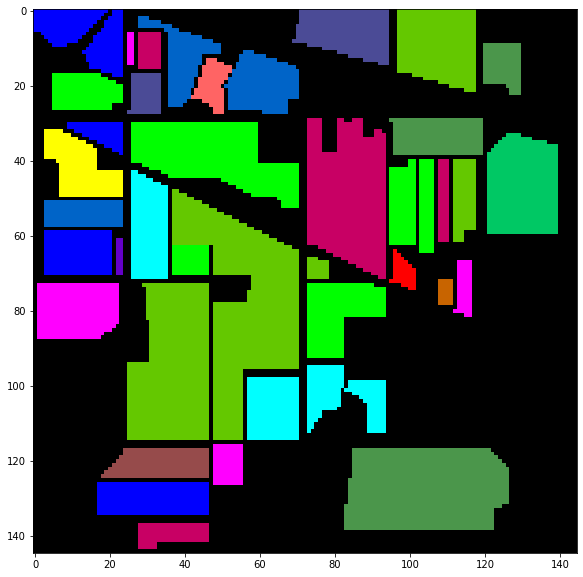

In [122]:
ground_truth = imshow(classes=y, figsize=(10, 10))

In [123]:
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, y.max() - y.min(), testRatio)
X_all = np.append(X_train, X_test, axis=0)
y_all = np.append(y_train, y_test, axis=0)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
# X_all, y_all = oversampleWeakClasses(X_all, y_all)
X_train = AugmentData(X_train)
# X_all = AugmentData(X_all)

TRAIN: [2781 6279 3297 ... 5097 4914 8964] TEST: [9084 4074 8765 ... 5807 6894 3023]
TRAIN: [9762 4184 1288 ... 1774 4117 9458] TEST: [7558 5539 7520 ... 9634 8226 1214]
TRAIN: [ 6181  4966  5682 ...  7371  9168 10179] TEST: [ 365 6960 4462 ... 4461 5348 9490]
TRAIN: [ 524 6368 9843 ... 4748 3740 6226] TEST: [7370 4467 6938 ... 9257 9670 3850]
TRAIN: [7774  929 1779 ... 1812 8760 7467] TEST: [2613 5255 6617 ... 6102 1677 1270]
TRAIN: [8792  188 9644 ... 4201 6541  334] TEST: [7302 6714 1305 ... 5907 1646 2514]
TRAIN: [2570 3125 1351 ... 1440 2466 2590] TEST: [6309 6106 5418 ... 9067 9133 6891]
TRAIN: [1476 7519 8645 ... 9738 7632 7565] TEST: [9276 1017 7027 ... 4251  773  912]
TRAIN: [1395 1189 7202 ... 6329 4528 7629] TEST: [6627  423 6973 ... 6191  943 2590]
TRAIN: [2571   56 3512 ... 7903 3706 3749] TEST: [7619 7003 7977 ... 9377 5280  980]
TRAIN: [1398 7438  995 ... 5524 8306  696] TEST: [ 690 6741 9688 ... 7389 9343 3096]
TRAIN: [2647  795 7710 ... 5010 1338 9358] TEST: [  836   9

In [124]:
# print(XPatches.shape)
print('X_train shape: ', X_train.shape)
# print(yPatches.shape)
print('y_train shape: ', y_train.shape)
#  (batch_size, height, width, channels)
#  batch_size当成总的训练样本数，height和width图片的长宽，channels为图片的通道数，类似于彩色图片的rgb三通道
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (19788, 17, 17, 30)
y_train shape:  (19788,)
X_test shape:  (5125, 17, 17, 30)
y_test shape:  (5125,)


In [125]:
# save Preprocessed Data to file
savePreprocessedData('predata', X_train, X_test, y_train, y_test,
                     X_all, y_all, windowSize=windowSize,
                     wasPCAapplied=True, numPCAComponents=numComponents,
                     testRatio=testRatio)

In [126]:
# Import the necessary libraries
import numpy as np
import scipy
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
# K.set_image_dim_ordering('th')
# K.set_image_data_format('channels_first')  # 这个data_format参数是这样影响input_shape工作的如果不填写，默认是channels_last，否则可以填写channels_first。前者的会把input_shape这个三元组给识别成(batch_size, height, width, channels)，后者则会识别成(batch_size, channels, height, width)
from keras.utils import np_utils

In [127]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm,
# the number of retained features  n
numPCAcomponents = 30
# Patches windows size
windowSize = 17
# The proportion of Test sets
testRatio = 0.50

In [128]:
X_train = np.load("./predata/XtrainWindowSize"
                  + str(windowSize) + "PCA" + str(numPCAcomponents) +
                  "testRatio" + str(testRatio) + ".npy")
y_train = np.load("./predata/ytrainWindowSize"
                  + str(windowSize) + "PCA" + str(numPCAcomponents) +
                  "testRatio" + str(testRatio) + ".npy")
X_test = np.load("./predata/XtestWindowSize"
                 + str(windowSize) + "PCA" + str(numPCAcomponents) +
                 "testRatio" + str(testRatio) + ".npy")
y_test = np.load("./predata/ytestWindowSize"
                 + str(windowSize) + "PCA" + str(numPCAcomponents) +
                 "testRatio" + str(testRatio) + ".npy")

In [129]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],
                               X_train.shape[2], X_train.shape[3]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],
                             X_test.shape[2], X_test.shape[3]))

# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Define the input shape
input_shape = X_train[0].shape  # 也可再Conv2d中设置input_shape=input_shape[1:]
print('input shape: ', input_shape)

input shape:  (17, 17, 30)


In [130]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (19788, 17, 17, 30)
y_train shape:  (19788, 16)


In [131]:
# # number of filters
# C1 = 3*numPCAcomponents

In [132]:
# # Define the model structure
# model = Sequential()
#
# model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
# model.add(Conv2D(3*C1, (3, 3), activation='relu'))
# model.add(Dropout(0.25))
#
# model.add(Flatten())
# model.add(Dense(6*numPCAcomponents, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='softmax'))

In [280]:
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.models import  model_from_json
from tensorflow.keras.models import load_model

In [224]:
RDB_num = 2
filters = 64
one_conv_num = 3
growth_rate = 32

In [225]:
class one_conv(layers.Layer):
	def __init__(self, out_channel, **kwargs):
		super(one_conv, self).__init__(**kwargs)
		self.out_channel = out_channel
		self.conv = layers.Conv2D(out_channel, kernel_size=3, padding="same", strides=1)
		self.relu = layers.ReLU()

	def call(self, inputs):
		x = self.conv(inputs)
		x = self.relu(x)
		x = layers.concatenate([inputs, x], 3)
		return x

	def get_config(self):
		config = super().get_config().copy()
		config.update({
			'out_channel': self.out_channel
		})
		return config

In [226]:
class rdb(layers.Layer):
	def __init__(self, filters, one_conv_num, growth_rate, **kwargs):
		super(rdb, self).__init__(**kwargs)
		self.filters = filters  # 除残差密集模块中的卷积层外的层滤波器个数
		self.one_conv_num = one_conv_num  # the number of RDB 模块个数
		self.growth_rate = growth_rate  # 增长比率，残差密集模块3x3核的输出个数
		convs = []
		for i in range(0, one_conv_num):
			convs.append(one_conv(growth_rate))
		self.conv = Sequential(convs)
		#local_feature_fusion
		self.LFF = layers.Conv2D(filters, kernel_size=1, padding="same", strides=1)  # 特征融合层
		self.add = layers.Add()
		self.relu = layers.ReLU()

	def call(self, inputs):
		x = self.conv(inputs)
		x = self.relu(x)
		lff = self.LFF(x)
		lff = self.relu(lff)
		#local residual learning
		x = self.add([inputs, lff])
		return x

	def get_config(self):
		config = super().get_config().copy()
		config.update({
			'filters': self.filters,
			'one_conv_num': self.one_conv_num,
			'growth_rate': self.growth_rate
		})
		return config

In [227]:
class RDB(layers.Layer):
	def __init__(self, filters, one_conv_num, growth_rate, **kwargs):
		super(RDB, self).__init__(**kwargs)
		self.filters = filters
		self.one_conv_num = one_conv_num
		self.growth_rate = growth_rate
		self.conv = layers.Conv2D(filters, kernel_size=3, padding='same', strides=1)
		self.rdbs = rdb(filters, one_conv_num, growth_rate)
		self.MaxPool2D = layers.MaxPool2D(pool_size=3, padding='same', strides=1)

	def call(self, inputs):
		x = self.conv(inputs)
		x = self.rdbs(x)
		x = self.MaxPool2D(x)
		x = layers.concatenate([inputs, x], 3)
		return x

	def get_config(self):
		config = super().get_config().copy()
		config.update({
			'filters': self.filters,
			'one_conv_num': self.one_conv_num,
			'growth_rate': self.growth_rate
		})
		return config

In [228]:
def _make_layer(block, RDB_num, filters, one_conv_num, growth_rate):
	layers_list = []
	for i in range(RDB_num):
		layers_list.append(block(filters, one_conv_num, growth_rate))
	return Sequential(layers_list)

In [229]:
# def _make_layer(block, RDB_num, filters, one_conv_num, growth_rate):
#     layers_list = []
#     for i in range(RDB_num):
#         layers_list.append(block(filters,one_conv_num,growth_rate))
#         layers_list.append(layers.MaxPooling2D(pool_size=1,padding="SAME"))
#     return Sequential(layers_list)

In [230]:
def _rdn(RDB_num, filters, one_conv_num, growth_rate, im_width=17, im_height=17, numclasses=16):
	input_image = layers.Input(shape=(im_height, im_width, 30), dtype="float32")
	x = layers.Conv2D(filters=64, kernel_size=3, padding="SAME", strides=2, use_bias=False)(input_image)
	x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
	x = layers.ReLU()(x)
	identity = x

	x = _make_layer(RDB, RDB_num, filters, one_conv_num, growth_rate)(x)

	# dense feature fusion(DFF)功能：全局特征学习
	x = layers.Conv2D(filters=64, kernel_size=1, padding="SAME")(x)  # 全局特征融合
	x = layers.ReLU()(x)
	x = layers.Conv2D(filters=64, kernel_size=3, padding="SAME")(x)  # 全局特征融合
	x = layers.ReLU()(x)
	x = layers.add([x, identity])  #全局残差学习

	x = layers.GlobalMaxPool2D()(x)  # pool + flatten
	x = layers.Dense(numclasses)(x)
	predict = layers.Softmax()(x)

	model = Model(inputs=input_image, outputs=predict)

	return model

In [274]:
def rdn(RDB_num=2, filters=64, one_conv_num=3, growth_rate=32, im_width=17, im_height=17, num_classes=16):
	return _rdn(RDB_num, filters, one_conv_num, growth_rate, im_width, im_height, num_classes)

In [275]:
model = rdn(RDB_num=2, filters=64, one_conv_num=3, growth_rate=32, im_width=17, im_height=17, num_classes=16)

In [276]:
# model_file = open('./json/HSI_model_epochs100.json', 'r')
# model_json = model_file.read()
# model_file.close()
# model = model_from_json(model_json)
# model.load_weights('./model/HSI_model_epochs100.h5', custom_objects={'one_conv': one_conv, 'rdb': rdb, 'RDB': RDB})

In [281]:
# model = load_model('./model/HSI_model_epochs100.h5', custom_objects={'one_conv': one_conv, 'rdb': rdb, 'RDB': RDB})

In [283]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 17, 17, 30)] 0                                            
__________________________________________________________________________________________________
conv2d_3093 (Conv2D)            (None, 9, 9, 64)     17280       input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 9, 9, 64)     256         conv2d_3093[0][0]                
__________________________________________________________________________________________________
re_lu_119 (ReLU)                (None, 9, 9, 64)     0           batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [284]:
# Define optimization and train method
# monitor：监测的值，可以是accuracy，val_loss,val_accuracy
# factor：缩放学习率的值，学习率将以lr = lr*factor的形式被减少
# patience：当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
# mode：‘auto’，‘min’，‘max’之一 默认‘auto’就行
# epsilon：阈值，用来确定是否进入检测值的“平原区”
# cooldown：学习率减少后，会经过cooldown个epoch才重新进行正常操作
# min_lr：学习率最小值，能缩小到的下限
# verbose(bool)-如果为True，则为每次更新向stdout输出一条消息。默认值：False。

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=5, min_lr=0.000001, verbose=1)

# 该回调函数将在每个epoch后保存模型到filepath
# filepath，保存模型的路径，里面的占位符将会被epoch值和传入on_epoch_end的logs关键字所填入
# monitor：需要监视的值，通常为：val_accuracy 或 val_loss 或 accuracy 或 loss
# verbose：信息展示模式，0或1。为1表示输出epoch模型保存信息，默认为0表示不输出该信息，信息形如：
# Epoch 00001: val_acc improved from -inf to 0.49240, saving model to /xxx/checkpoint/model_001-0.3902.h5
# save_best_only：当设置为True时，将只保存在验证集上性能最好的模型
# mode：‘auto’，‘min’，‘max’之一，在save_best_only=True时决定性能最佳模型的评判准则，例如，当监测值为val_acc时，模式应为max，当检测值为val_loss时，模式应为min。在auto模式下，评价准则由被监测值的名字自动推断。
# save_weights_only：若设置为True，则只保存模型权重，否则将保存整个模型（包括模型结构，配置信息等）
# period：CheckPoint之间的间隔的epoch数

checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", verbose=1, save_best_only=False)
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [285]:
# Start to train model
history = model.fit(X_train, y_train,
					batch_size=32,
					epochs=10,
					verbose=1,
					validation_data=(X_test, y_test),
					callbacks=[reduce_lr, checkpointer],
					shuffle=True)

Epoch 1/10
222/619 [=========>....................] - ETA: 5s - loss: 0.0014 - accuracy: 1.0000

KeyboardInterrupt: 

In [237]:
# model_json = model.to_json()
# with open('./json/HSI_model_epochs100.json', 'w') as ejson_file:
# 	ejson_file.write(model_json)
# model.save('./model/HSI_model_epochs100.h5')
# print('Model saved.')

Model saved.


In [286]:
# save the model with h5py
import h5py
from keras.models import load_model
model.save('./model/HSI_model_epochs100.h5')
print('Model saved.')
# model.save('model')

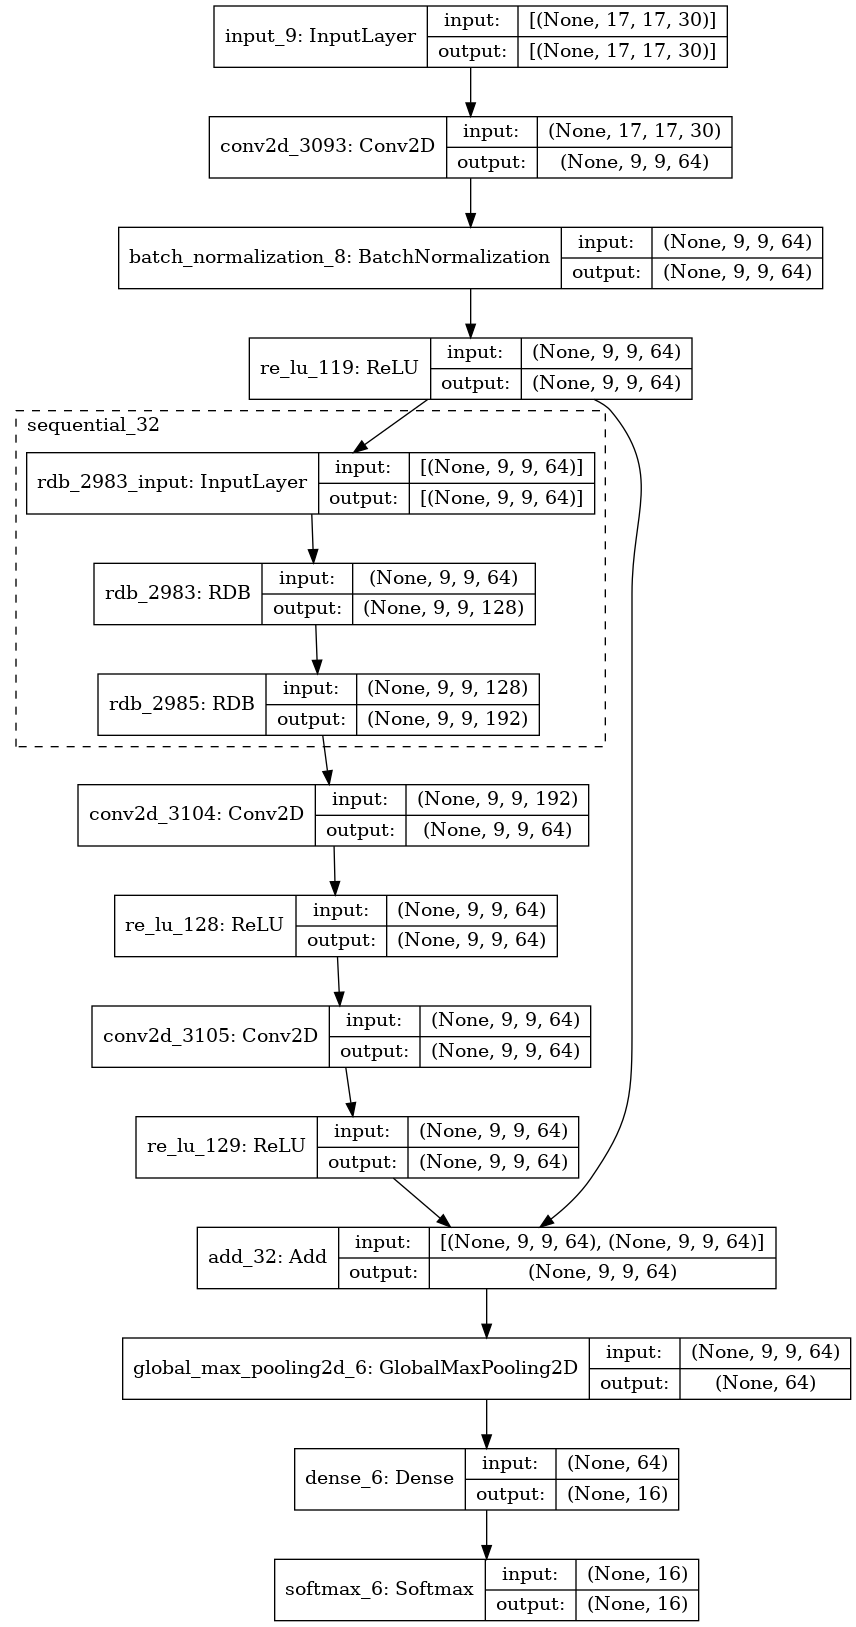

In [239]:
# using plot_model module to save the model figure
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='./model/model.png', show_shapes=True, show_layer_names=True, rankdir='TB',
		   expand_nested=True)
# print(history.history.keys())

In [240]:
# print(model)

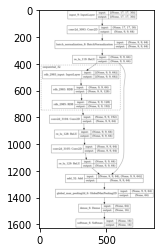

In [241]:
import matplotlib.pyplot as plt

# get_ipython().run_line_magic('matplotlib', 'inline')
model_img = plt.imread('./model/model.png')
plt.imshow(model_img)
plt.show()

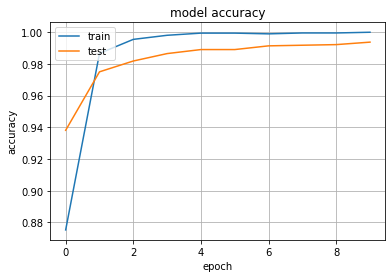

In [242]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left')
# os.mkdir(os.path.join(os.getcwd(), 'result'))
plt.savefig("./result/model_accuracy_100.svg")
plt.show()

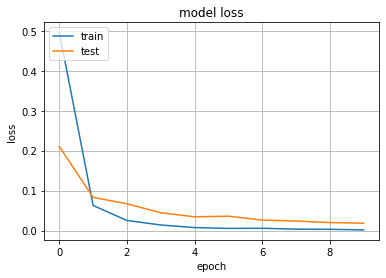

In [243]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./result/model_loss_100.svg")
plt.show()

In [265]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from tensorflow.keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from tensorflow.keras.utils import get_custom_objects
import itertools
import spectral
from operator import truediv
from tqdm import tqdm

In [245]:
# Define the neccesary functions for later use
# load the Indian pines dataset which is the .mat format
def loadIndianPinesData():
	data_path = os.path.join(os.getcwd(), 'data')
	data = sio.loadmat(os.path.join(data_path, 'Indian_pines.mat'))['indian_pines']
	labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']

	return data, labels

In [246]:
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']

In [247]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [248]:
def reports(X_test, y_test):
	Y_pred = model.predict(X_test)
	y_pred = np.argmax(Y_pred, axis=1)

	classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names, digits=4)
	confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
	score = model.evaluate(X_test, y_test, batch_size=32)

	oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
	each_acc, aa = AA_andEachClassAccuracy(confusion)
	kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
	Test_Loss = score[0] * 100
	Test_accuracy = score[1] * 100
	oa = oa*100
	each_acc = each_acc*100
	aa = aa*100
	kappa = kappa*100
	return classification, confusion, Test_Loss, Test_accuracy, oa, each_acc, aa, kappa

In [249]:
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    margin = int((PATCH_SIZE - 1) / 2)
    zeroPaddedX = padWithZeros(data, margin=margin)
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = zeroPaddedX[height_slice, width_slice, :]

    return patch

In [250]:
# show current path
PATH = os.getcwd()
print (PATH)

/root/autodl-tmp


In [251]:
# Read PreprocessedData from file

X_test = np.load("./predata/XtestWindowSize"
				 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
y_test = np.load("./predata/ytestWindowSize"
				 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

# X_test = np.load("./predata/XAllWindowSize"
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
# y_test = np.load("./predata/yAllWindowSize"
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]))
y_test = np_utils.to_categorical(y_test)

In [252]:
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_test shape:  (5125, 17, 17, 30)
y_test shape:  (5125, 16)


In [253]:
# load the model architecture and weights
model = load_model('./model/HSI_model_epochs100.h5', custom_objects={'one_conv': one_conv, 'rdb': rdb, 'RDB': RDB})

In [254]:
# calculate result, loss, accuray and confusion matrix
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test, y_test)
classification = str(classification)
confusion_str = str(confusion)

# show result and save to file
print('Test loss {} (%)'.format(Test_loss))
print('Test accuracy {} (%)'.format(Test_accuracy))
print('Kappa accuracy {} (%)'.format(kappa))
print('Overall accuracy {} (%)'.format(oa))
print('Average accuracy {} (%)'.format(aa))
print("classification result: ")
print('{}'.format(classification))
print("confusion matrix: ")
print('{}'.format(confusion_str))
file_name = './result/report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(
	testRatio) + ".txt"
with open(file_name, 'w') as x_file:
	x_file.write('Test loss {} (%)'.format(Test_loss))
	x_file.write('\n')
	x_file.write('Test accuracy {} (%)'.format(Test_accuracy))
	x_file.write('\n')
	x_file.write('Kappa accuracy {} (%)'.format(kappa))
	x_file.write('\n')
	x_file.write('Overall accuracy {} (%)'.format(oa))
	x_file.write('\n')
	x_file.write('Average accuracy {} (%)'.format(aa))
	x_file.write('\n')
	x_file.write('\n')
	x_file.write(" classification result: \n")
	x_file.write('{}'.format(classification))
	x_file.write('\n')
	x_file.write(" confusion matrix: \n")
	x_file.write('{}'.format(confusion_str))

161/161 [==============================] - 1s 6ms/step - loss: 0.0184 - accuracy: 0.9938
Test loss 1.8436076119542122 (%)
Test accuracy 99.3756115436554 (%)
Kappa accuracy 99.2880550836991 (%)
Overall accuracy 99.37560975609756 (%)
Average accuracy 99.17481379000542 (%)
classification result: 
                              precision    recall  f1-score   support

                     Alfalfa     0.9583    1.0000    0.9787        23
                 Corn-notill     0.9930    0.9944    0.9937       714
                Corn-mintill     1.0000    0.9904    0.9952       415
                        Corn     0.9440    1.0000    0.9712       118
               Grass-pasture     0.9958    0.9793    0.9875       242
                 Grass-trees     1.0000    0.9945    0.9973       365
         Grass-pasture-mowed     1.0000    1.0000    1.0000        14
               Hay-windrowed     1.0000    1.0000    1.0000       239
                        Oats     1.0000    1.0000    1.0000        10
    

In [255]:
import matplotlib.pyplot as plt


# get_ipython().run_line_magic('matplotlib', 'inline')
def plot_confusion_matrix(cm, classes,
						  normalize=False,
						  title='Confusion matrix',
						  cmap=plt.get_cmap("Blues")):
	"""
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
	Normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
	if normalize:
		cm = Normalized
		print("Normalized confusion matrix")
	else:
		print('Confusion matrix, without normalization')

	print(cm)

	plt.imshow(Normalized, interpolation='nearest', cmap=cmap)
	plt.colorbar()
	plt.title(title)
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation=90)
	plt.yticks(tick_marks, classes)

	fmt = '.4f' if normalize else 'd'
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		thresh = cm[i].max() / 2.
		plt.text(j, i, format(cm[i, j], fmt),
				 horizontalalignment="center",
				 color="white" if cm[i, j] > thresh else "black")

	plt.tight_layout()
	plt.ylabel('True label')
	plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  23    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  710    0    0    0    0    0    0    0    0    2    1    0    0
     0    0]
 [   0    0  411    4    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  118    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0  237    0    0    0    0    5    0    0    0    0
     0    0]
 [   0    0    0    2    0  363    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0   14    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  239    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   10    0    0    0    0    0
     0    0]
 [   0    2    0    0    0    0    0    0    0  483    1    0    0    0
     0    0]
 [   0    3    0    0    0    0    0    0    0    0 1225    0    0    0
     0    0]
 [   0    0    0    1    

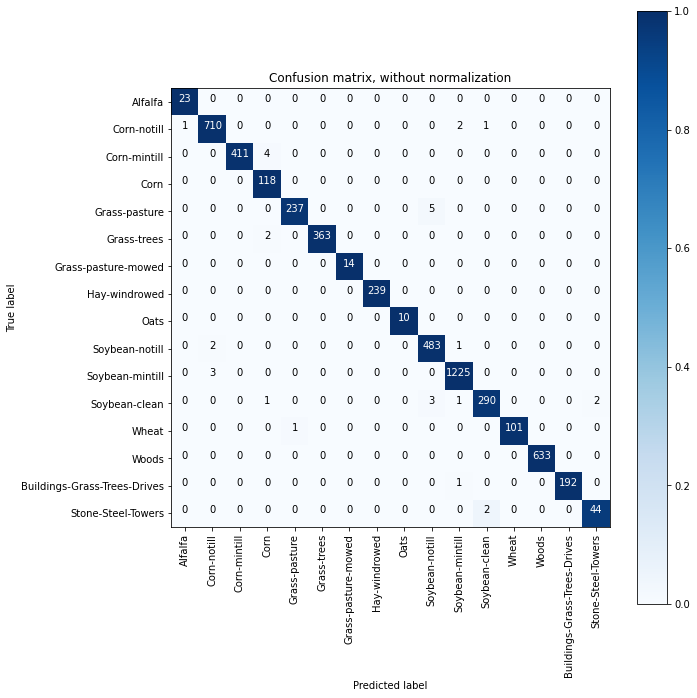

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00140056 0.99439776 0.         0.         0.         0.
  0.         0.         0.         0.         0.00280112 0.00140056
  0.         0.         0.         0.        ]
 [0.         0.         0.99036145 0.00963855 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.97933884 0.
  0.         0.         0.         0.02066116 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00547945 0.         0.99452055
  0.         0.         0.         0.         0.         0.
 

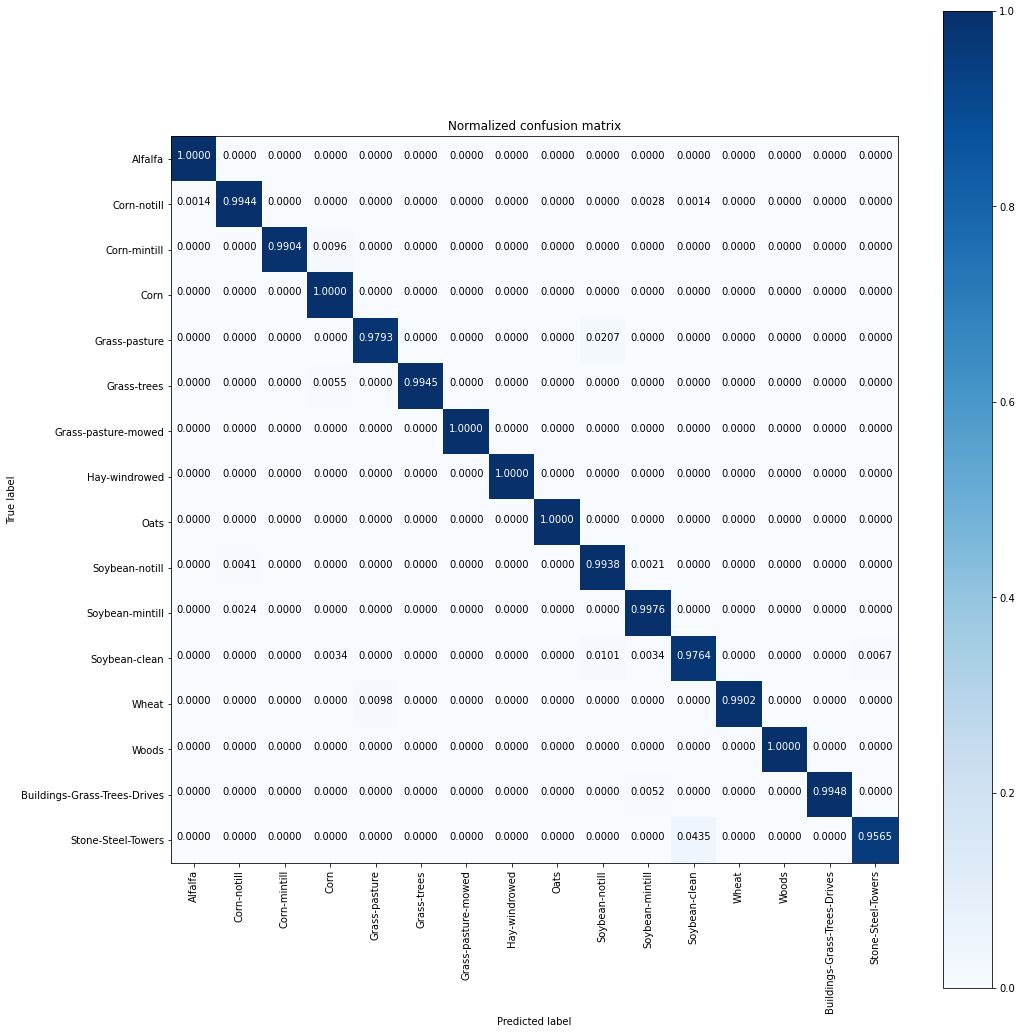

In [256]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(confusion, classes=target_names, normalize=False, title='Confusion matrix, without normalization')
plt.savefig("./result/confusion_matrix_without_normalization.svg")
plt.show()
plt.figure(figsize=(10, 10))
plot_confusion_matrix(confusion, classes=target_names, normalize=True, title='Normalized confusion matrix')
plt.savefig("./result/confusion_matrix_with_normalization.svg")
plt.show()

In [257]:
# # load the original image
X, y = loadIndianPinesData()
# # X, y = loadHSIData()
X, pca = applyPCA(X, numComponents=numPCAcomponents)

In [258]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 17

In [259]:
print('X_shape: ',X.shape)
print('y_shape: ',y.shape)

X_shape:  (145, 145, 30)
y_shape:  (145, 145)


In [272]:
# calculate the predicted image
outputs = np.zeros((height, width))
for i in tqdm(range(height)):
	for j in range(width):
		target = y[i][j]
		if target == 0:
			continue
		else:
			image_patch = Patch(X, i, j)
			# print (image_patch.shape)
			X_test_image = image_patch.reshape(1, image_patch.shape[0], image_patch.shape[1],
											   image_patch.shape[2]).astype('float32')
			# print(X_test_image.shape)
			# prediction = np.argmax(model.predict(X_test_image),axis=1)
			prediction = model.predict(X_test_image)
			prediction = np.argmax(prediction, axis=1)
			# (model.predict_classes(X_test_image))
			outputs[i][j] = prediction + 1

  1%|▏         | 2/145 [00:07<09:24,  3.94s/it]


KeyboardInterrupt: 

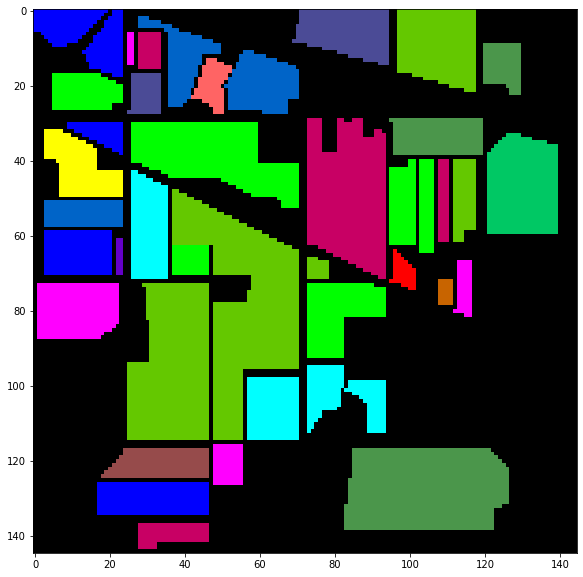

In [269]:
ground_truth = spectral.imshow(classes=y, figsize=(10, 10))

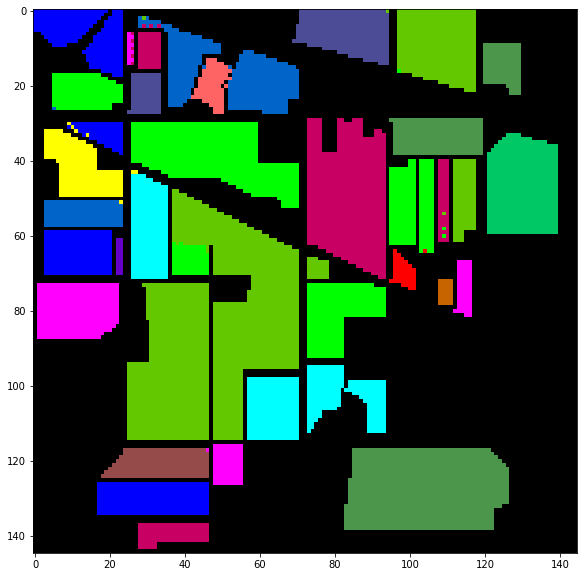

In [270]:
predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(10, 10))